# Regional Tracer Budget in POP

`pop-tools` has a module for computing tracer budgets over the POP grid. The main function, `regional_tracer_budget`, closes a tracer budget given an `xarray.Dataset` with the appropriate variables and a mask for the POP grid.


In [1]:
%matplotlib inline
import pop_tools
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

Note that the input `xr.Dataset` has to be pre-processed in a specific manner for the tracer budget to carry through properly. One needs to supply a dataset with advection terms (`UE`, `VN`, `WT`), diffusion terms (`HDIFE`, `HDIFN`, `HDIFB`), diabatic mixing (`DIA_IMPVF`), and KPP (`KPP_SRC`). Additional terms could include virtual fluxes for DIC (`FvICE`, `FvPER`), surface tracer fluxes (`STF`), and source/sink terms (`J_${tracer}`).

Output variables for POP's ecosystem model, BEC, can be found [here](http://www.cesm.ucar.edu/models/cesm1.2/pop2/doc/users/POPecosys_main.html). This includes a table of all budget terms and their description.

In [2]:
help(pop_tools.budget.regional_tracer_budget)

Help on function regional_tracer_budget in module pop_tools.budget:

regional_tracer_budget(ds, grid, mask=None, mask_int=None, budget_depth=None, sum_depth=True, sum_area=True)
    Return a regional tracer budget on the POP grid.
    
    Parameters
    ----------
    ds : `xarray.Dataset`
      Dataset containing global POP output, with the tracer suffix removed:
      * UE
      * VN
      * WT
      * HDIFE
      * HDIFN
      * HDIFB
      * DIA_IMPVF
      * KPP_SRC
      * FvICE (optional)
      * FvPER (optional)
      * STF (optional; rename from FG_{tracer} for CO2)
      * SMS (optional; rename from J_{tracer})
    grid : str
      POP grid (e.g., POP_gx3v7, POP_gx1v7, POP_tx0.1v3)
    mask : `xarray.DataArray`, optional
      Mask on POP grid with integers for region of interest. If None, use REGION_MASK.
    mask_int : int
      Number corresponding to integer on mask. E.g., 1 for the Southern Ocean for REGION_MASK.
    budget_depth : int, optional
      Depth to compute b

We will start out by starting a `dask-jobqueue` cluster on Cheyenne's Casper nodes. You can find information on how to get started on `dask-jobqueue` here: https://dask-jobqueue.readthedocs.io/en/latest/. I used a config file (`~/.config/dask/jobqueue.yaml`) to store my project code. This asks for 2 nodes of 120GB of memory with 6 processes each. Thus, we get 12 workers with 6 cores and 20GB of memory.

In [3]:
from dask_jobqueue import SLURMCluster
NUMNODES=2
cluster = SLURMCluster(cores=36, memory="120 GB", processes=6, walltime='01:00:00')
cluster.scale(NUMNODES*4)

In [4]:
from dask.distributed import Client
client = Client(cluster)

In [28]:
client

Client Scheduler: tcp://10.12.205.30:41653 Dashboard: /proxy/8787/status,Cluster Workers: 12 Cores: 72 Memory: 240.00 GB


## Atlantic Ocean Iron Budget

In our demo case, we'll calculate an iron budget over the upper 100m of the Atlantic Ocean. We can use `REGION_MASK` for this, which comes as the default mask for the `pop-tools` tracer budget module.

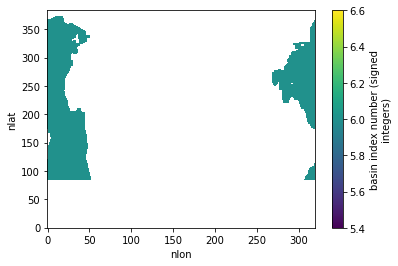

In [6]:
mask = pop_tools.get_grid('POP_gx1v7')['REGION_MASK']
mask.where(mask==6).plot()

### Pre-process the Output

We need to prepare our dataset for `pop-tools` with proper naming conventions. We'll use output from a forced ocean-sea ice (FOSI) experiment that is in the main glade directory.

In [7]:
filenames = {
        'UE': 'g.e11_LENS.GECOIAF.T62_g16.009.pop.h.ecosys.nyear1.UE_Fe.0249-0316.nc',
        'VN': 'g.e11_LENS.GECOIAF.T62_g16.009.pop.h.ecosys.nyear1.VN_Fe.0249-0316.nc',
        'WT': 'g.e11_LENS.GECOIAF.T62_g16.009.pop.h.ecosys.nyear1.WT_Fe.0249-0316.nc',
        'HDIFE': 'g.e11_LENS.GECOIAF.T62_g16.009.pop.h.ecosys.nyear1.HDIFE_Fe.0249-0316.nc', 
        'HDIFN': 'g.e11_LENS.GECOIAF.T62_g16.009.pop.h.ecosys.nyear1.HDIFN_Fe.0249-0316.nc',
        'HDIFB': 'g.e11_LENS.GECOIAF.T62_g16.009.pop.h.ecosys.nyear1.HDIFB_Fe.0249-0316.nc',
        'DIA_IMPVF': 'g.e11_LENS.GECOIAF.T62_g16.009.pop.h.ecosys.nyear1.DIA_IMPVF_Fe.0249-0316.nc',
        'KPP_SRC': 'g.e11_LENS.GECOIAF.T62_g16.009.pop.h.ecosys.nyear1.KPP_SRC_Fe.0249-0316.nc',
#        These terms are only used for DIC budgets.
#        'FvICE': '',
#        'FvPER': '',
        'STF': 'g.e11_LENS.GECOIAF.T62_g16.009.pop.h.IRON_FLUX.024901-031612.nc',
        'SMS': 'g.e11_LENS.GECOIAF.T62_g16.009.pop.h.Jint_100m_Fe.024901-031612.nc',
}

In [8]:
def load_tracer_terms(basepath, filenames, tracer):
    """
    Loads in the tracer terms given a base directory path, a dictionary of output file names,
    and a tracer name. This needs to be modified for different simulations that might integrate
    some terms, only provide annual output, etc.
    """
    ds = xr.Dataset()
    for new_var, raw_var in filenames.items():
        print(f'{new_var}...')
        if (tracer == 'Fe') and (new_var == 'STF'):
            # Converts to nmol/cm2/s, as in other tracer fluxes.
            ds_i = xr.open_dataset(f'{basepath}/{filenames[new_var]}')['IRON_FLUX'] * 100
        elif (tracer == 'Fe') and (new_var == 'SMS'):
            ds_i = xr.open_dataset(f'{basepath}/{filenames[new_var]}')['Jint_100m_Fe']
        else:
            ds_i = xr.open_dataset(f'{basepath}/{filenames[new_var]}')[f'{new_var}_{tracer}']
        
        # Rename all vertical dimensions to `z_t`. This isn't mandatory, since the 
        # tracer budget module will do this for you. But it makes chunking the dask
        # arrays easier.
        if 'z_w_bot' in ds_i.dims:
            ds_i = ds_i.drop('z_w_bot')
            ds_i = ds_i.rename({'z_w_bot': 'z_t'})
        if 'z_w_top' in ds_i.dims:
            ds_i = ds_i.drop('z_w_top')
            ds_i = ds_i.rename({'z_w_top': 'z_t'})    
        ds_i = ds_i.rename(new_var).to_dataset()
        
        # Chunking forces this dataset into dask arrays so that we can take advantage
        # of its out-of-memory computation.
        if new_var not in ['STF', 'SMS']:
            ds_i = ds_i.chunk({'time': 10, 'z_t': 10, 'nlat': 100, 'nlon': 100})
        else:
            ds_i = ds_i.chunk({'time': 100, 'nlat': 100, 'nlon': 100})
        ds = ds.merge(ds_i)
    
    # Critical: Make sure to make your time array a datetime array. The budget module will
    # use this to convert all terms to annual means.
    ds['time'] = np.arange('1948-01', '2016-01', dtype='datetime64[M]')
    ds = ds.chunk({'time': 10, 'z_t': 10, 'nlat': 100, 'nlon': 100})
    return ds

In [9]:
basepath = '/glade/p/cesm/community/CESM-DPLE/CESM-DPLE_POPCICEhindcast'
tracer = 'Fe'
ds = load_tracer_terms(basepath, filenames, tracer)
ds = ds.reset_coords(drop=True)

UE...
VN...
WT...
HDIFE...
HDIFN...
HDIFB...
DIA_IMPVF...
KPP_SRC...
STF...
SMS...


In [10]:
ds.info()

xarray.Dataset {
dimensions:
	nlat = 384 ;
	nlon = 320 ;
	time = 816 ;
	z_t = 60 ;

variables:
	datetime64[ns] time(time) ;
	float64 z_t(z_t) ;
		z_t:units = centimeters ;
		z_t:long_name = depth from surface to midpoint of layer ;
		z_t:valid_min = 500.0 ;
		z_t:valid_max = 537500.0 ;
		z_t:positive = down ;
	float32 UE(time, z_t, nlat, nlon) ;
		UE:grid_loc = 3211 ;
		UE:long_name = Fe Flux in grid-x direction ;
		UE:cell_methods = time: mean ;
		UE:units = mmol/m^3/s ;
	float32 VN(time, z_t, nlat, nlon) ;
		VN:grid_loc = 3121 ;
		VN:long_name = Fe Flux in grid-y direction ;
		VN:cell_methods = time: mean ;
		VN:units = mmol/m^3/s ;
	float32 WT(time, z_t, nlat, nlon) ;
		WT:grid_loc = 3112 ;
		WT:long_name = Fe Flux Across Top Face ;
		WT:cell_methods = time: mean ;
		WT:units = mmol/m^3/s ;
	float32 HDIFE(time, z_t, nlat, nlon) ;
		HDIFE:grid_loc = 3211 ;
		HDIFE:long_name = Fe Horizontal Diffusive Flux in grid-x direction ;
		HDIFE:cell_methods = time: mean ;
		HDIFE:units = mmol/m

And now the tracer computation is as simple as feeding it into the `regional_tracer_budget` function. We pass `mask_int=6` for the `REGION_MASK` integer for the Atlantic Ocean and `budget_depth=100` to constrain the budget to the upper 100m.

You can watch the progress of this computation with the dask dashboard. See the [pangeo guide](http://pangeo.io/setup_guides/hpc.html) on this to follow along.

### Compute and Validate the Tracer Budget

Note that `pop_tools` returns a lazy budget computation. I.e., you can save it out as a `dask` object to compute later, or can run `.compute()` or `.load()` to compute it immediately.

In [11]:
%%time 
ds = pop_tools.regional_tracer_budget(ds, 'POP_gx1v7', mask_int=6, budget_depth=100)

/glade/u/home/rbrady/miniconda3/envs/python3/lib/python3.7/site-packages/pop_tools/budget.py:320: UserWarning: FvICE and FvPER are not in the input dataset and thus virtual fluxes will not be computed.
  'FvICE and FvPER are not in the input dataset and thus virtual fluxes will not be computed.'


CPU times: user 2.56 s, sys: 231 ms, total: 2.79 s
Wall time: 2.78 s


In [12]:
%%time
ds = ds.compute()

CPU times: user 1min 56s, sys: 13.2 s, total: 2min 10s
Wall time: 3min 11s


The output dataset contains a time-series of the budget terms summed over the entire control volume in units of `mol/yr`. By passing the keyword `sum_area=False` and/or `sum_depth=False` to `regional_tracer_budget`, one can get area- and depth-resolved budgets.

In [13]:
print(ds)

<xarray.Dataset>
Dimensions:  (time: 68)
Coordinates:
  * time     (time) int64 1948 1949 1950 1951 1952 ... 2011 2012 2013 2014 2015
Data variables:
    ladv     (time) float64 -5.537e+07 -5.633e+07 ... -7.529e+07 -7.03e+07
    vadv     (time) float64 -8.894e+07 -6.572e+07 ... -7.9e+07 -8.67e+07
    lmix     (time) float64 -8.543e+07 -9.336e+07 ... -9.305e+07 -1.093e+08
    vmix     (time) float64 5.014e+08 4.677e+08 ... 4.737e+08 4.806e+08
    SMS      (time) float64 -3.375e+09 -3.211e+09 ... -3.292e+09 -3.222e+09
    stf      (time) float64 3.025e+09 3.025e+09 ... 3.025e+09 3.025e+09
Attributes:
    units:    mol/yr


We can validate this budget with the `tend_zint_100m_Fe` output over the same domain. It's useful to go through this exercise when working with a new variable to ensure that you have included all appropriate terms. It's easy to miss the unit conversion on `IRON_FLUX`, for instance.

In [14]:
tend_int = xr.open_dataset(basepath + '/g.e11_LENS.GECOIAF.T62_g16.009.pop.h.tend_zint_100m_Fe.024901-031612.nc',
                           decode_times=False, decode_coords=False)['tend_zint_100m_Fe'].chunk({'time': 12})
tend_int['time'] = np.arange('1948-01', '2016-01', dtype='datetime64[M]')
grid = pop_tools.get_grid('POP_gx1v7')

# boolean mask for the Atlantic
mask = (grid.REGION_MASK == 6)
tend_int = tend_int.where(mask)

In [15]:
# Integrate over the same volume.
tend_int = (tend_int * grid.TAREA).sum(['nlat', 'nlon'])

# Convert from nmol/s to mol/yr
tend_int *= 1e-9 * 86400.0 * 365.0

# Resample to annual resolution
tend_int = tend_int.groupby('time.year').mean('time').rename({'year': 'time'})
tend_int = tend_int.compute()

A quick check confirms that the sum of our individual budget terms is close to the saved out iron tendency.

Text(0.5, 1.0, 'Model Tendency and Budget Approximation of Atlantic Ocean Iron')

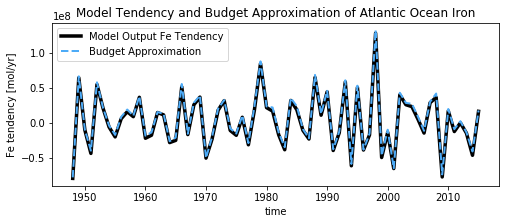

In [16]:
f, ax = plt.subplots(figsize=(8, 3))
tend_int.plot(color='k', linewidth=3.5, label='Model Output Fe Tendency')
ds.to_array().sum('variable').plot(color='#4dabf7', linestyle='--', linewidth=2,
                                   label='Budget Approximation')
plt.legend()
ax.set_ylabel('Fe tendency [mol/yr]')
ax.set_title('Model Tendency and Budget Approximation of Atlantic Ocean Iron')

## Custom Mask

One can also compute a regional tracer budget over a custom POP mask, i.e., one that is not contained in `REGION_MASK`. We can slice out a section of the equatorial Pacific for this example.

In [17]:
import cartopy.crs as ccrs
grid = pop_tools.get_grid('POP_gx1v7')

In [18]:
# Create a mask of just 1's, since we'll slice it down and use this as our index.
mask = xr.full_like(grid.TLAT, fill_value=1)

# Using `xarray`s where function to fill in mask with a specific integer.
mask = mask.where( (grid.TLAT >= -5) & (grid.TLAT <= 5) & (grid.TLONG >= 190) & (grid.TLONG <=240) )

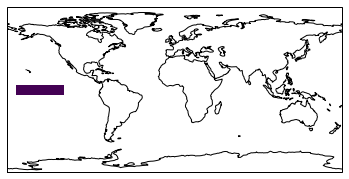

In [19]:
f, ax = plt.subplots(subplot_kw=dict(projection=ccrs.PlateCarree()))
ax.pcolormesh(grid.TLONG, grid.TLAT, mask, transform=ccrs.PlateCarree())
ax.coastlines()

In [21]:
basepath = '/glade/p/cesm/community/CESM-DPLE/CESM-DPLE_POPCICEhindcast'
tracer = 'Fe'
ds = load_tracer_terms(basepath, filenames, tracer)
ds = ds.reset_coords(drop=True)

UE...
VN...
WT...
HDIFE...
HDIFN...
HDIFB...
DIA_IMPVF...
KPP_SRC...
STF...
SMS...


Now we just pass in the optional `mask` keyword with our mask, along with the integer we assigned to the equatorial Pacific (1).

In [22]:
%%time 
ds = pop_tools.regional_tracer_budget(ds, 'POP_gx1v7', mask=mask, mask_int=1, budget_depth=100)

CPU times: user 2.75 s, sys: 213 ms, total: 2.96 s
Wall time: 2.94 s


/glade/u/home/rbrady/miniconda3/envs/python3/lib/python3.7/site-packages/pop_tools/budget.py:320: UserWarning: FvICE and FvPER are not in the input dataset and thus virtual fluxes will not be computed.
  'FvICE and FvPER are not in the input dataset and thus virtual fluxes will not be computed.'


In [23]:
%%time
ds = ds.load()

distributed.utils_perf - WARNING - full garbage collections took 20% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 21% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 22% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 11% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took 12% CPU time recently (threshold: 10%)
distributed.utils_perf - WARNING - full garbage collections took

CPU times: user 1min 52s, sys: 10.7 s, total: 2min 3s
Wall time: 3min 9s


We can now do any sort of visualization and analysis on the budget terms.

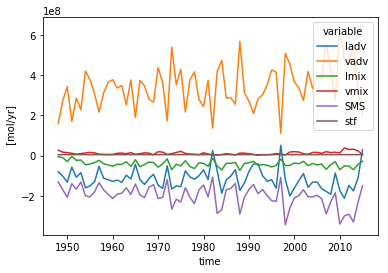

In [27]:
ds.to_array().plot(hue='variable')